In [1]:
#!/usr/bin/env python3
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from train import *
from visual_functions import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow_addons.optimizers import *
%matplotlib inline

## ---------------------- load data ----------------------------------------
ins, os, hpr, rn = (72,32,1), 15, (24, 33), 0.08
gen = SynthGen(ins, os, hpr, rn)
x_train, y_train = gen.create_dataset(160)
x_test, y_test = gen.create_dataset(10)

Welcome to JupyROOT 6.26/00
Creating dataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1553.95it/s]


Creating dataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1067.36it/s]


## Use learning rate schedules for faster convergence

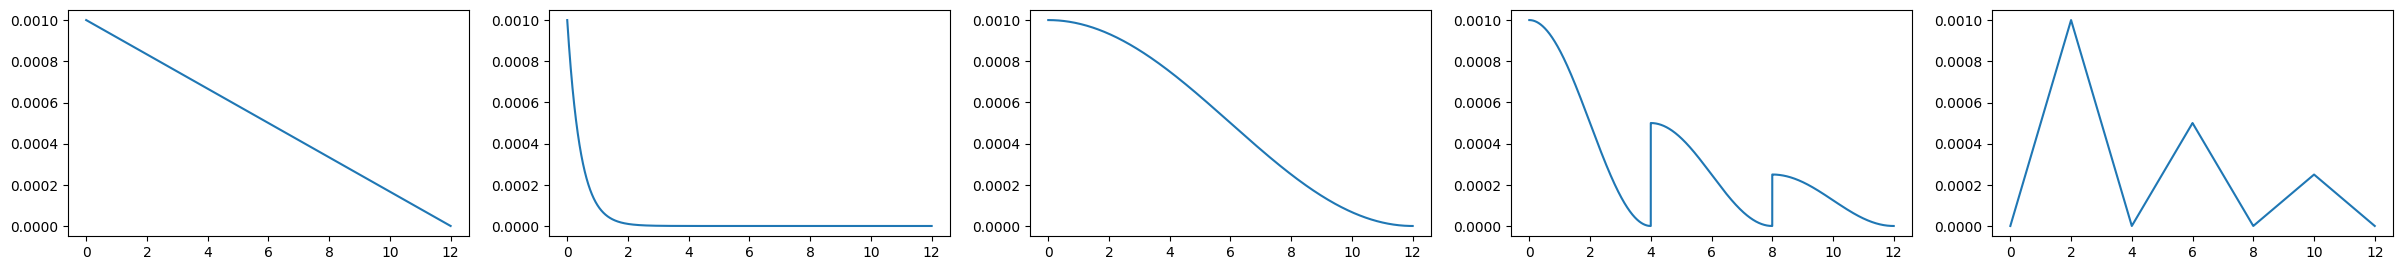

2022-04-19 15:38:11.895588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 15:38:11.920937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 15:38:11.921080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 15:38:11.921717: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
plt.rcParams['figure.figsize'] = [30, 3]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
epochs = 12
spe = 5000
lin = PolynomialDecay(0.001, epochs*spe, 1e-6)
ed = ExponentialDecay(0.001, spe, 0.1)
cd = CosineDecay(0.001, epochs*spe, alpha=0.0)
cdr = CosineDecayRestarts(0.001,
                          first_decay_steps=4*spe,
                          t_mul=1.0,
                          m_mul=0.5,
                          alpha=1e-6)
tclr = Triangular2CyclicalLearningRate(1e-6, 0.001, 2*spe)



steps = np.arange(0, epochs*spe)
methods = np.array([lin, ed, cd, cdr, tclr])
fig, ax = plt.subplots(1, 5)
for i, m in enumerate(methods):
    ep = np.arange(0, epochs)
    lr = []
    for e in range(epochs):
        steps = np.arange(e*spe, (e+1)*spe)
        lr.append(np.mean(m(steps)))
    #ax[i].scatter(ep, lr)
    
    steps = np.arange(0, epochs*spe)
    ax[i].plot(steps/spe, m(steps))

## Find optimal learning rate range

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 72, 32, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 36, 16, 64)        36928     
                                                             

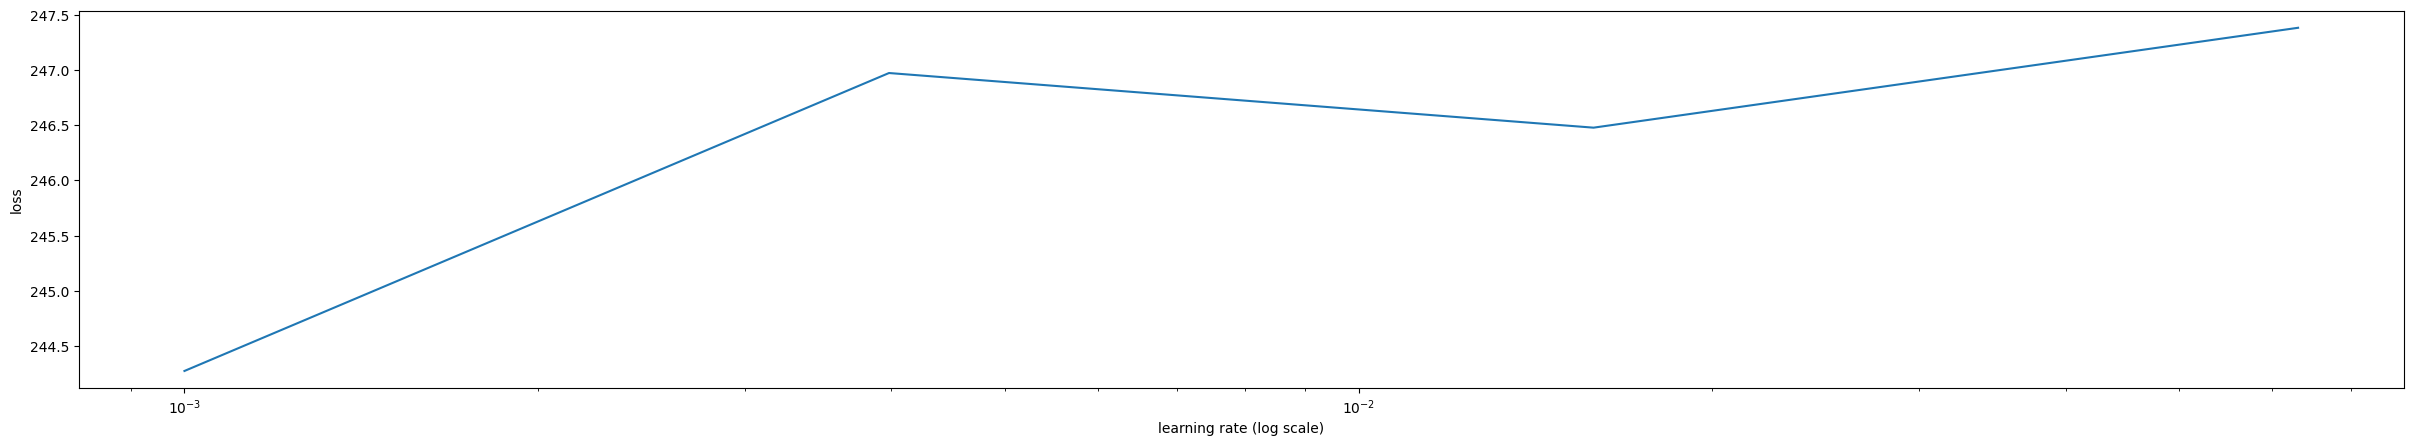

2022-04-19 15:38:13.711859: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


In [3]:
from keras_lr_finder import LRFinder
model = get_model_no_config(ins, os)
plt.rcParams['figure.figsize'] = [30, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#lr = CyclicalLearningRate(config.init_lr, config.max_lr, scale_fn=lambda x: 1/(2.**(x-1)), step_size=3*config.spe)
lr = 0.001
opt= Adam(lr)
model.compile(optimizer=opt, loss="mse", metrics=["accuracy"])

lr_finder = LRFinder(model)
lr_finder.find(x_train, y_train, start_lr=1e-9, end_lr=1, batch_size=32, epochs=3)
lr_finder.plot_loss(n_skip_end=1)
plt.show()

## transform to stepwise decay in order to use it for tmva

In [4]:
nums = [2**n*12 for n in range(10)]
resets = [np.sum(nums[:n]) for n in range(10)]
resets

[0.0, 12, 36, 84, 180, 372, 756, 1524, 3060, 6132]

0,0.0009958383;1,0.0009875133;2,0.0009791884;3,0.00097086333;4,0.00096253835;5,0.0009542133;6,0.00094588834;7,0.0009375633;8,0.0009292384;9,0.0009209133;10,0.0009125883;11,0.0009042633;12,0.00089593837;13,0.0008876134;14,0.0008792885;15,0.0008709634;16,0.00086263835;17,0.00085431326;18,0.0008459883;19,0.00083766336;20,0.00082933845;21,0.00082101335;22,0.0008126884;23,0.0008043632;24,0.00079603837;25,0.00078771333;26,0.00077938836;27,0.0007710634;28,0.00076273835;29,0.00075441337;30,0.00074608834;31,0.0007377634;32,0.0007294383;33,0.0007211134;34,0.0007127884;35,0.00070446334;36,0.00069613836;37,0.0006878134;38,0.00067948835;39,0.0006711634;40,0.00066283834;41,0.00065451337;42,0.00064618833;43,0.00063786336;44,0.0006295383;45,0.00062121334;46,0.0006128883;47,0.00060456333;48,0.0005962383;49,0.0005879133;50,0.00057958835;51,0.0005712633;52,0.00056293834;53,0.00055461336;54,0.0005462883;55,0.0005379634;56,0.0005296384;57,0.00052131334;58,0.00051298836;59,0.0005046634;60,0.00049633835;61,0

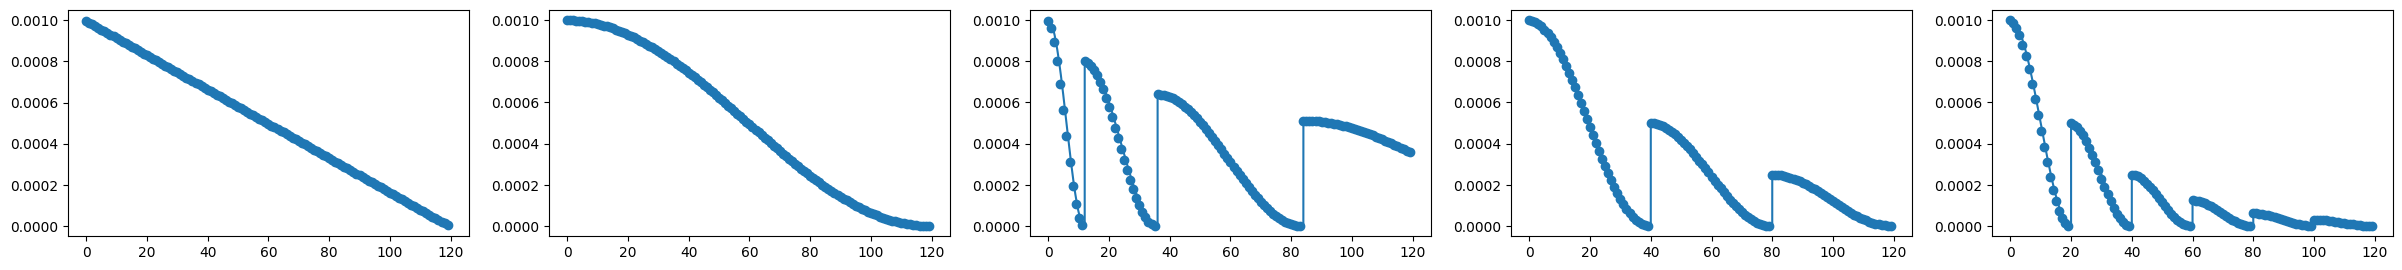

In [6]:
plt.rcParams['figure.figsize'] = [30, 3]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
epochs = 120
spe = 5000
lin = PolynomialDecay(0.001, epochs*spe, 1e-6)
cd = CosineDecay(0.001, epochs*spe, alpha=0.0)
tclr = Triangular2CyclicalLearningRate(1e-6, 0.001, 2*spe)
cdr = CosineDecayRestarts(0.001,
                          first_decay_steps=12*spe,
                          t_mul=2.0,
                          m_mul=0.8,
                          alpha=1e-6)
cdr2 = CosineDecayRestarts(0.001,
                          first_decay_steps=40*spe,
                          t_mul=1.0,
                          m_mul=0.5,
                          alpha=1e-6)
cdr3 = CosineDecayRestarts(0.001,
                          first_decay_steps=20*spe,
                          t_mul=1.0,
                          m_mul=0.5,
                          alpha=1e-6)



steps = np.arange(0, epochs*spe)
methods = np.array([lin, cd, cdr, cdr2, cdr3])
fig, ax = plt.subplots(1, 5)
for i, m in enumerate(methods):
    ep = np.arange(0, epochs)
    lr = []
    for e in range(epochs):
        steps = np.arange(e*spe, (e+1)*spe)
        lr.append(np.mean(m(steps)))
    ax[i].scatter(ep, lr)
    steps = np.arange(0, epochs*spe)
    ax[i].plot(steps/spe, m(steps))
    tmva_string = ""
    for e, l in zip(ep, lr):
        tmva_string += str(e) + "," + str(l) + ";"
    print(tmva_string)
    print()